<a href="https://colab.research.google.com/github/SCain1996/github-activity-SCain1996/blob/main/Copy_of_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to google drive so that the images can be processed

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/downloads/ISIC-images'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.JPG')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.JPG')))
print(image_count_test)

2000
1000


Processing Data

In [ ]:
root_path = '/content/drive/MyDrive/downloads/ISIC-images'
data_dir_train = pathlib.Path(root_path + '/Train/Train-Images')
data_dir_test = pathlib.Path(root_path + '/Test/Test-Images')

In [ ]:
train_metadata = pd.read_csv(data_dir_train / 'metadata.csv')
test_metadata = pd.read_csv(data_dir_test / 'metadata1.csv')

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
def load_images_and_labels(data_dir, metadata, image_list, label_list, desired_width, desired_height):
    for index, row in metadata.iterrows():
        # Read image file
        image_path = os.path.join(data_dir, row['isic_id'] + '.JPG')
        image = Image.open(image_path)
        # Resize image if needed
        image = image.resize((desired_width, desired_height))
        # Convert image to numpy array
        image_array = np.array(image)
        image_list.append(image_array)
        # Associate label with image
        label_list.append(row['benign_malignant'])


In [ ]:
# Desired width and height for resizing images
desired_width = 50
desired_height = 50

In [ ]:
load_images_and_labels(data_dir_train, train_metadata, train_images, train_labels, desired_width, desired_height)

In [ ]:
load_images_and_labels(data_dir_test, test_metadata, test_images, test_labels, desired_width, desired_height)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (2000, 50, 50, 3)
Train labels shape: (2000,)
Test images shape: (1000, 50, 50, 3)
Test labels shape: (1000,)


Balancing the data

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
oversampler = RandomOverSampler()
balanced_train_images, balanced_train_labels = oversampler.fit_resample(train_images.reshape(-1, 50 * 50 * 3), train_labels)

In [ ]:
balanced_train_images = balanced_train_images.reshape(-1, 50, 50, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_train_images, balanced_train_labels, test_size=0.2, random_state=42)

In [ ]:
label_mapping = {"benign": 0, "malignant": 1}


In [ ]:
def map_label(label):
    return label_mapping.get(label, -1)  # Return -1 for unknown labels

In [ ]:
test_labels = np.array([map_label(label) for label in test_labels])


In [ ]:
y_train = np.array([map_label(label) for label in y_train])


In [ ]:
y_test = np.array([map_label(label) for label in y_test])


In [ ]:
print("Updated y_train dtype:", y_train.dtype)
print("Updated y_test dtype:", y_test.dtype)
print("Updated y_train shape:", y_train.shape)
print("Updated y_test shape:", y_test.shape)


Updated y_train dtype: int64
Updated y_test dtype: int64
Updated y_train shape: (5184,)
Updated y_test shape: (1296,)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
test_labels = test_labels.astype('int64')


In [ ]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train dtype: uint8
y_train dtype: int64
X_test dtype: uint8
y_test dtype: int64
X_train shape: (5184, 50, 50, 3)
y_train shape: (5184,)
X_test shape: (1296, 50, 50, 3)
y_test shape: (1296,)


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 64)                4

In [ ]:
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_data=(X_test_normalized, y_test))


Epoch 1/10
162/162 [==============================] - 24s 137ms/step - loss: -39366.1484 - accuracy: 0.2469 - val_loss: -239655.9531 - val_accuracy: 0.2585
Epoch 2/10
162/162 [==============================] - 18s 110ms/step - loss: -1993548.0000 - accuracy: 0.2479 - val_loss: -6738249.5000 - val_accuracy: 0.2585
Epoch 3/10
162/162 [==============================] - 18s 112ms/step - loss: -17446974.0000 - accuracy: 0.2479 - val_loss: -41354100.0000 - val_accuracy: 0.2585
Epoch 4/10
162/162 [==============================] - 18s 110ms/step - loss: -73612752.0000 - accuracy: 0.2479 - val_loss: -140927072.0000 - val_accuracy: 0.2585
Epoch 5/10
162/162 [==============================] - 24s 150ms/step - loss: -203919392.0000 - accuracy: 0.2479 - val_loss: -349175360.0000 - val_accuracy: 0.2585
Epoch 6/10
162/162 [==============================] - 18s 112ms/step - loss: -447853088.0000 - accuracy: 0.2479 - val_loss: -702969472.0000 - val_accuracy: 0.2585
Epoch 7/10
162/162 [================

In [ ]:

evaluation_results = model.evaluate(X_test_normalized, y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])


41/41 [==============================] - 1s 25ms/step - loss: -4450054656.0000 - accuracy: 0.2585
Test Loss: -4450054656.0
Test Accuracy: 0.25848764181137085


Evaluate for other metrics

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Evaluate the model on the test dataset
evaluation_results = model.evaluate(X_test_normalized, y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

y_pred_proba = model.predict(X_test_normalized)

y_pred = np.where(y_pred_proba > 0.5, 1, 0)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))




41/41 [==============================] - 2s 43ms/step - loss: -4450054656.0000 - accuracy: 0.2585
Test Loss: -4450054656.0
Test Accuracy: 0.25848764181137085
41/41 [==============================] - 2s 45ms/step

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       654
           0       0.26      1.00      0.41       335
           1       0.00      0.00      0.00       307

    accuracy                           0.26      1296
   macro avg       0.09      0.33      0.14      1296
weighted avg       0.07      0.26      0.11      1296



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Visualise Data

Epoch 1/10
162/162 [==============================] - 17s 107ms/step - loss: -4634852864.0000 - accuracy: 0.2479 - val_loss: -6197852160.0000 - val_accuracy: 0.2585
Epoch 2/10
162/162 [==============================] - 17s 108ms/step - loss: -6371383808.0000 - accuracy: 0.2479 - val_loss: -8416544768.0000 - val_accuracy: 0.2585
Epoch 3/10
162/162 [==============================] - 17s 107ms/step - loss: -8552379392.0000 - accuracy: 0.2479 - val_loss: -11223374848.0000 - val_accuracy: 0.2585
Epoch 4/10
162/162 [==============================] - 19s 119ms/step - loss: -11211827200.0000 - accuracy: 0.2479 - val_loss: -14422685696.0000 - val_accuracy: 0.2585
Epoch 5/10
162/162 [==============================] - 17s 107ms/step - loss: -14364662784.0000 - accuracy: 0.2479 - val_loss: -18345723904.0000 - val_accuracy: 0.2585
Epoch 6/10
162/162 [==============================] - 17s 105ms/step - loss: -18066049024.0000 - accuracy: 0.2479 - val_loss: -22955876352.0000 - val_accuracy: 0.2585
Epo

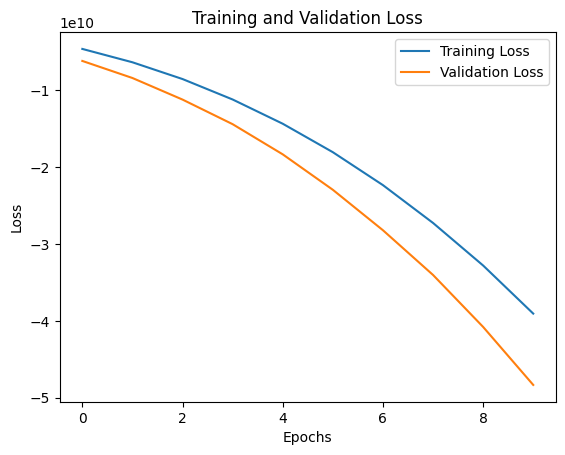

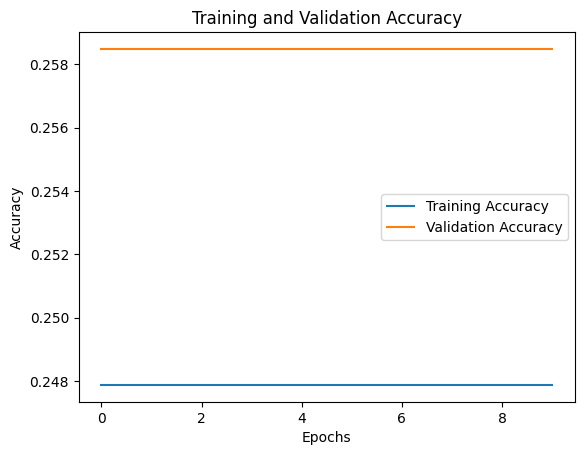

In [ ]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_data=(X_test_normalized, y_test))

# Evaluate the model on the test dataset
evaluation_results = model.evaluate(X_test_normalized, y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Pre trained model for comparison using VGG16



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model (excluding top/classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Create a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_data=(X_test_normalized, y_test))

# Evaluate the model
evaluation_results = model.evaluate(X_test_normalized, y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/10
162/162 [==============================] - 195s 1s/step - loss: -12.2130 - accuracy: 0.2477 - val_loss: -33.5671 - val_accuracy: 0.2623
Epoch 2/10
162/162 [==============================] - 192s 1s/step - loss: -73.2826 - accuracy: 0.2537 - val_loss: -128.3300 - val_accuracy: 0.2647
Epoch 3/10
162/162 [==============================] - 189s 1s/step - loss: -194.7835 - accuracy: 0.2539 - val_loss: -284.8142 - val_accuracy: 0.2670
Epoch 4/10
162/162 [==============================] - 192s 1s/step - loss: -376.7095 - accuracy: 0.2546 - val_loss: -501.6311 - val_accuracy: 0.2670
Epoch 5/10
162/162 [==============================] - 188s 1s/step - loss: -616.7401 - accuracy: 0.2550 - val_loss: -775.9128 - val_accuracy: 0.2677
Epoch 6/10
162/162 [==============================] - 187s 1s/step - loss: -911.3641 - accuracy: 0.2548 - val_loss: -1106.9114 - val_accuracy: 0.2677
Epoch 7/10
162/162 [=======================

In [ ]:
from sklearn.metrics import classification_report

# Predict probabilities
y_pred_proba = model.predict(X_test_normalized)
# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)
# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load data
root_path = '/content/drive/MyDrive/downloads/ISIC-images'
data_dir_train = os.path.join(root_path, 'Train/Train-Images')
data_dir_test = os.path.join(root_path, 'Test/Test-Images')

# Load metadata
train_metadata = pd.read_csv(os.path.join(data_dir_train, 'metadata.csv'))
test_metadata = pd.read_csv(os.path.join(data_dir_test, 'metadata1.csv'))

# Load images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

def load_images_and_labels(data_dir, metadata, image_list, label_list, desired_width, desired_height):
    for index, row in metadata.iterrows():
        image_path = os.path.join(data_dir, row['isic_id'] + '.JPG')
        image = Image.open(image_path)
        image = image.resize((desired_width, desired_height))
        image_array = np.array(image)
        image_list.append(image_array)
        label_list.append(row['benign_malignant'])

desired_width = 50
desired_height = 50

load_images_and_labels(data_dir_train, train_metadata, train_images, train_labels, desired_width, desired_height)
load_images_and_labels(data_dir_test, test_metadata, test_images, test_labels, desired_width, desired_height)

# Convert lists to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)

# Define model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(desired_width, desired_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
evaluation_results = model.evaluate(test_images, test_labels_encoded)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load images and labels function
def load_images_and_labels(data_dir, metadata, desired_width, desired_height):
    images = []
    labels = []
    for index, row in metadata.iterrows():
        image_path = os.path.join(data_dir, row['isic_id'] + '.JPG')
        image = Image.open(image_path)
        image = image.resize((desired_width, desired_height))
        image_array = np.array(image)
        images.append(image_array)
        labels.append(row['benign_malignant'])
    return np.array(images), labels

# Load and preprocess data
root_path = '/content/drive/MyDrive/downloads/ISIC-images'
data_dir_train = os.path.join(root_path, 'Train/Train-Images')
data_dir_test = os.path.join(root_path, 'Test/Test-Images')

train_metadata = pd.read_csv(os.path.join(data_dir_train, 'metadata.csv'))
test_metadata = pd.read_csv(os.path.join(data_dir_test, 'metadata1.csv'))

desired_width = 50
desired_height = 50

train_images, train_labels = load_images_and_labels(data_dir_train, train_metadata, desired_width, desired_height)
test_images, test_labels = load_images_and_labels(data_dir_test, test_metadata, desired_width, desired_height)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)

# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Encode labels with LabelEncoder that includes all possible labels
label_encoder = LabelEncoder()
all_labels = np.concatenate((train_labels, test_labels))  # Combine all labels for fitting
label_encoder.fit(all_labels)

# Encode the labels into integers
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),  # Adjust the input shape based on your actual image size
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(len(np.unique(all_labels)), activation='softmax')  # Output layer adjusted for number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(train_images, train_labels_encoded, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
evaluation_results = model.evaluate(test_images, test_labels_encoded)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the test images (if not already normalized)
normalized_test_images = test_images / 255.0

# Predict classes with the model
predictions = model.predict(normalized_test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Identifying unique labels present in the test set
unique_labels_in_test = np.unique(test_labels_encoded)
target_names = [label_encoder.classes_[i] for i in unique_labels_in_test]

# Calculate and print the classification report
print("\nClassification Report:")
report = classification_report(test_labels_encoded, predicted_classes, labels=unique_labels_in_test, target_names=target_names)
print(report)

# Generate and print the confusion matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes, labels=unique_labels_in_test)
print("\nConfusion Matrix:")
print(cm)

# Visualization of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
